<a href="https://colab.research.google.com/github/davidabelin/doubledigits/blob/main/double_digits_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classifying Handwritten Digits with Neural Networks

![img](https://www.tensorflow.org/images/MNIST.png)

**Learning Objectives:**
  * Train both a linear model and a neural network to classify handwritten digits from the classic [MNIST](http://yann.lecun.com/exdb/mnist/) data set
  * Compare the performance of the linear and neural network classification models
  * Visualize the weights of a neural-network hidden layer

Our goal is to map each input image to the correct numeric digit. We will create a NN with a few hidden layers and a Softmax layer at the top to select the winning class.

## Setup

First, let's download the data set, import TensorFlow and other utilities, and load the data into a *pandas* `DataFrame`. Note that this data is a sample of the original MNIST training data; we've taken 20000 rows at random.

In [2]:
from __future__ import print_function

import glob
import math
import os
import random as rd
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.data import Dataset

#tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.3f}'.format

In [3]:
#@title HOMEMADE IMPORTS
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sbn

import zipfile
import math
import random as rd
import numpy as np
import pandas as pd
import os, signal
from IPython import display
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad

In [4]:
mnist_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
N = 10000
mnist_dataframe = mnist_dataframe.head(N)

#mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each row represents one labeled example. Column 0 represents the label that a human rater has assigned for one handwritten digit. For example, if Column 0 contains '6', then a human rater interpreted the handwritten character as the digit '6'.  The ten digits 0-9 are each represented, with a unique class label for each possible digit. Thus, this is a multi-class classification problem with 10 classes.

Columns 1 through 784 contain the feature values, one per pixel for the 28×28=784 pixel values. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent shades of gray. Most of the pixel values are 0; you may want to take a minute to confirm that they aren't all 0.  For example, adjust the following text block to print out the values in column 72.

Now, let's parse out the labels and features and look at a few examples. Note the use of `loc` which allows us to pull out columns based on original location, since we don't have a header row in this data set.

In [5]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255

  return labels, features

## Make double digits
* make double digit images with labels 0 - 99

In [6]:
dd_targets, dd_examples = parse_labels_and_features(mnist_dataframe)

In [7]:
def getDDs(n):
    ## slow?
    new_examples = pd.DataFrame(columns=[r for r in range(1568)])
    new_targets = []
    for i in range(n):
        left = rd.choice(dd_examples.index.values)   
        right = rd.choice(dd_examples.index.values)

        answer = dd_targets[left]*10 + dd_targets[right]
        new_targets += [answer]

        bkgrnd = np.zeros((28,56))   
        bkgrnd[:,0:28] += dd_examples.loc[left].values.reshape((28,28))
        bkgrnd[:,28:56] += dd_examples.loc[right].values.reshape((28,28))
        if i%200 == 0:
            print ("Image",i,"of",n,"\tLabel =",answer)
            display.clear_output(wait=True)
        bkgrnd = pd.Series(bkgrnd.reshape(1568))
        new_examples = new_examples.append(bkgrnd, ignore_index=True)
    return pd.Series(new_targets), new_examples

In [8]:
validation_targets, validation_examples = getDDs(2000)    #(N//5)
training_targets, training_examples = getDDs(6000)      #(4*N//5)
#training_examples

Image 5800 of 6000 	Label = 65


In [ ]:
train_6000, valid_2000 = training_examples, validation_examples
train_6000["target"] = training_targets
valid_2000["target"] = validation_targets

In [25]:
train_6000.to_csv("doubledigits_train_6000")
valid_2000.to_csv("doubledigits_valid_2000")


Show a random example and its corresponding label.

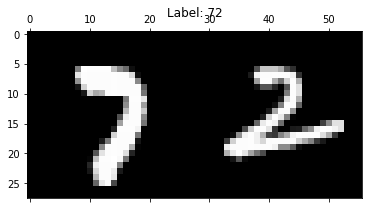

In [22]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 56),cmap="binary_r")
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

In [10]:
N,len(set(training_targets)),len(set(validation_targets))

(10000, 100, 100)

## Task 1: Build a Linear Model for MNIST

First, let's create a baseline model to compare against. The `LinearClassifier` provides a set of *k* one-vs-all classifiers, one for each of the *k* classes.

You'll notice that in addition to reporting accuracy, and plotting Log Loss over time, we also display a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).  The confusion matrix shows which classes were misclassified as other classes. Which digits get confused for each other?

Also note that we track the model's error using the `log_loss` function. This should not be confused with the loss function internal to `LinearClassifier` that is used for training.

In [ ]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.
  Returns:
    A set of feature columns
  """ 
  # There are XXX pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=28*56)])

Here, we'll make separate input functions for training and for prediction. We'll nest them in `create_training_input_fn()` and `create_predict_input_fn()`, respectively, so we can invoke these functions to return the corresponding `_input_fn`s to pass to our `.train()` and `.predict()` calls.

In [ ]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])

    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(N+1)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [ ]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [ ]:
def train_linear_classification_model(
                                    periods,
                                    learning_rate,
                                    steps,
                                    batch_size,
                                    training_examples,
                                    training_targets,
                                    validation_examples,
                                    validation_targets):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  #periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
                            training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
                            validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
                            training_examples, training_targets, batch_size)
  
  # Create a LinearClassifier object.
  my_optimizer = tf.compat.v1.train.AdagradOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.compat.v1.estimator. clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.LinearClassifier(
                    feature_columns=construct_feature_columns(),
                    n_classes=100,
                    optimizer=my_optimizer,
                    #config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
    
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,100)
            
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,100)    
        
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        #training_accuracy = metrics.accuracy_score()
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)

        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)

  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

**Spend 5 minutes seeing how well you can do on accuracy with a linear model of this form. For this exercise, limit yourself to experimenting with the hyperparameters for batch size, learning rate and steps.**

Stop if you get anything above about 0.9 accuracy.

In [ ]:
classifier = train_linear_classification_model(
                            periods=3,
                            learning_rate=0.03,
                            steps=500,
                            batch_size=100,
                            training_examples=training_examples,
                            training_targets=training_targets,
                            validation_examples=validation_examples,
                            validation_targets=validation_targets)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpt7r2h1qg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
LogLoss error (on validation data):
Instructions for updating:
Use Variable.read_value. Variables i

ValueError: ignored

Here is a set of parameters that should attain roughly 0.9 accuracy.

In [ ]:
_ = train_linear_classification_model(
                periods = 10,
                learning_rate=0.03,
                steps=1000,
                batch_size=30,
                training_examples=training_examples,
                training_targets=training_targets,
                validation_examples=validation_examples,
                validation_targets=validation_targets)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe7fwpfhg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.

If you intended to run this 

ValueError: ignored

Next, we verify the accuracy on the test set.

In [ ]:
#mnist_test_dataframe = pd.read_csv(
#                        "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
#                        sep=",",
#                        header=None)

test_targets, test_examples = getDDs(1000)
test_examples

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
996,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [ ]:
predict_test_input_fn = create_predict_input_fn(test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

NameError: ignored

## Task 2: Replace the Linear Classifier with a Neural Network

**Replace the LinearClassifier above with a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) and find a parameter combination that gives 0.95 or better accuracy.**

You may wish to experiment with additional regularization methods, such as dropout. These additional regularization methods are documented in the comments for the `DNNClassifier` class.

The code below is almost identical to the original `LinearClassifer` training code, with the exception of the NN-specific configuration, such as the hyperparameter for hidden units.

In [ ]:
def train_nn_classification_model(
    periods,
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """
  n_classes = len(set(training_targets))
  #periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
            training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
            validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
            training_examples, training_targets, batch_size)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column('pixels', shape=28*56)]

  # Create a DNNClassifier object.
  my_optimizer = tf.optimizers.Adagrad(learning_rate=learning_rate)
  #my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
                    feature_columns=feature_columns,
                    n_classes=n_classes,
                    hidden_units=hidden_units,
                    optimizer=my_optimizer,
                    #config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
    
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, n_classes)
            
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, n_classes)    
        
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

In [ ]:
classifier = train_nn_classification_model(
                        periods=10,
                        learning_rate=0.02,
                        steps=1000,
                        batch_size=50,
                        hidden_units=[100, 100],
                        training_examples=training_examples,
                        training_targets=training_targets,
                        validation_examples=validation_examples,
                        validation_targets=validation_targets)

In [ ]:
#mnist_test_dataframe = pd.read_csv(
#  "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
#  sep=",",
#  header=None)

test_targets, test_examples = getDDs(1000)

predict_test_input_fn = create_predict_input_fn(test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

In [ ]:
predict_test_input_fn()

##Homemade model

In [ ]:
######################## Friendlier data
x_train = validation_examples.values.reshape(validation_examples.shape[0],28,56)
x_test = training_examples.values.reshape(training_examples.shape[0],28,56)
y_train, y_test = validation_targets, training_targets

######################## Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

####################### TF Datasets for input
train_ds = tf.data.Dataset.from_tensor_slices( (x_train, y_train) )
test_ds = tf.data.Dataset.from_tensor_slices( (x_test, y_test) )

In [ ]:
input_layer = layers.Input(shape=(28,56,1))
x = layers.Conv2D(30, 7, activation='relu')(input_layer) # 
x = layers.Conv2D(20, 5, activation='relu', padding='same')(x) 
#x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(10, 3, activation='relu', padding='same')(x) 
#x = layers.MaxPooling2D((2,4))(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dropout(0.05)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
####################### Build
diy_model = Model(input_layer, output_layer)

####################### Compile
diy_model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.005), #0.0075
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputs = [layer.output for layer in diy_model.layers[1:]]
diy_output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]
diy_model.summary()

In [ ]:
#############################
diy_history = diy_model.fit(train_ds.shuffle(N).batch(100),
                            validation_data=test_ds.batch(20),  
                            epochs=5,  
                            verbose=1)

In [ ]:
#@title Define show_layer_output()

def show_layer_output(model, output_model, dataset):
    """
    Inputs: model, output_model is layer outputs of model, dataset=a fully loaded tf Dataset of examples and targets
    Outputs: true answers, best guesses, the corresponding prediction probabilities for each,
             and the image being predicted
    """
    ############################ its own internal version of guessing()
    ############################ always returns image
    def guessing(n=1,model=model,dataset=dataset):
        answers, guesses, pA, pG = [],[],[],[]
        for count in range(n):
            take1_ds = dataset.shuffle(10001).take(1)
            for img, ans in take1_ds:
                ans = ans.numpy()
                img = img.numpy()                  # eg. 28x56x1
            img = img.reshape((1,) + img.shape)    # eg. 1x50x50x1
            guess_set = model.predict(img).flatten()
            #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
            guess = np.argmax(guess_set)       
            answers += [ans]
            guesses += [guess]
            pG += [guess_set[guess]]
            pA += [guess_set[ans]]
            print("Answer",ans,"\tGuess",guess, "\tp(A)",round(pA[count],2),"\tp(G)",round(pG[count],2))
            if count%10 == 0:
                print ('Processing...',count,"...")
                display.clear_output(wait=True)
        return answers, guesses, pA, pG, img
    ############################ 

    answers, guesses, pA, pG, img = guessing()
    print("Answer:",answers[0],"\tp(Answer):",round(pA[0],3))
    print("Guess:",guesses[0],"\tp(Guess):",round(pG[0],3))
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img[0,:,:,0]) 

    layer_output_maps = output_model.predict( img )
    layer_names = [layer.name for layer in model.layers[1:]]

    for layer_name, layer_map in zip(layer_names, layer_output_maps):
    ############################ your included / excluded layers here:
        print ("layer:",layer_name,"map shape:",layer_map.shape)
        if not "dense" in layer_name and not "dropout" in layer_name and not "flatten" in layer_name:
            #if "flatten" in layer_name:
    ############################ your image shape here:
                #layer_map = layer_map.reshape(1,50,50,10)
            n_maps = layer_map.shape[-1]  # number of maps
            grid_rows = max(1, n_maps//10)
            # Map has shape (1, rows, columns, n_maps)
            rows = layer_map.shape[1]
            cols = layer_map.shape[2]
            image_grid = np.zeros((rows * grid_rows, cols * min(10,n_maps)))

            for gridrow in range(grid_rows):
                for map_n in range(min(10,n_maps)):
                        x = layer_map[0, :, :, map_n+10*gridrow]
                        #x[-1:1,-1:1] = np.mean(x)
                        #x[0:0] = np.max(x)
                        #x[0:1,0:5] = np.mean(x)
                        #[0:1,5:] = np.max(x)
                        #x *= 255.0
                        image_grid[gridrow*rows:(gridrow+1)*rows , map_n*cols:(map_n+1)*cols] = x
                        
            scale = 2.2          
            plt.figure(figsize=(scale * 10, scale * grid_rows))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_grid, cmap='gray')

    return answers, guesses, pA, pG, img

In [ ]:
answers, guesses, pA, pG, img = show_layer_output(diy_model,diy_output_model,test_ds)

## Task 3: Visualize the weights of the first hidden layer.

Let's take a few minutes to dig into our neural network and see what it has learned by accessing the `weights_` attribute of our model.

The input layer of our model has `784` weights corresponding to the `28×28` pixel input images. The first hidden layer will have `784×N` weights where `N` is the number of nodes in that layer. We can turn those weights back into `28×28` images by *reshaping* each of the `N` `1×784` arrays of weights into `N` arrays of size `28×28`.

Run the following cell to plot the weights. Note that this cell requires that a `DNNClassifier` called "classifier" has already been trained.

####Original canned-DNN model

In [ ]:
print(classifier.get_variable_names())

In [ ]:
weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 56), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

####DIY model

In [ ]:
for v in diy_model.variables:
    print(v.name, v.shape)
#diy_model.get_layer('dense_14').kernel

In [ ]:
16*44

In [ ]:
weights = diy_model.get_layer('dense_51').kernel.numpy()
weights = weights.reshape(704, 10, 20)
weights = weights.reshape(704, 200)

print("weights shape:", weights.shape)

num_nodes = weights.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(weights.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(16, 44), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

The first hidden layer of the neural network should be modeling some pretty low level features, so visualizing the weights will probably just show some fuzzy blobs or possibly a few parts of digits.  You may also see some neurons that are essentially noise -- these are either unconverged or they are being ignored by higher layers.

It can be interesting to stop training at different numbers of iterations and see the effect.

**Train the classifier for 10, 100 and respectively 1000 steps. Then run this visualization again.**

What differences do you see visually for the different levels of convergence?

##Just NN layers

In [ ]:
input_layer = layers.Input(shape=(28,56,1))
x = layers.Flatten()(input_layer)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
####################### Build
nn_model = Model(input_layer, output_layer)

####################### Compile
nn_model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.005), #0.0075
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputs = [layer.output for layer in nn_model.layers[1:]]
nn_output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]
nn_model.summary()

In [ ]:
#############################
nn_history = nn_model.fit(train_ds.shuffle(N).batch(40),
                            validation_data=test_ds.batch(40),  
                            epochs=5,  
                            verbose=1)

In [ ]:
for v in nn_model.variables:
    print(v.name, v.shape)
#diy_model.get_layer('dense_14').kernel

In [ ]:
weights = nn_model.get_layer('dense_26').kernel.numpy()
print("weights shape:", weights.shape)

In [ ]:
weights = nn_model.get_layer('dense_26').kernel.numpy()
#weights = weights.reshape(1568,10,100)
#weights = weights.reshape(1568,1000)

print("weights shape:", weights.shape)

num_nodes = weights.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(weights.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 56), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()